In [6]:
# !pip uninstall scikit-learn imbalanced-learn pycaret -y
# !pip install scikit-learn==1.4.2 -q
# !pip install imbalanced-learn -q
# !pip install pycaret -q
# !pip install autoviz -q

In [7]:
# !pip install resampy==0.4.2 -q

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
%matplotlib inline
import seaborn as sns

# Specific Libraries
import os
import librosa
import librosa.display

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm, trange
from tqdm.auto import tqdm

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation , Dropout

import IPython.display as ipd
import resampy

# Analysing Data Type and Format

In [9]:
df = pd.read_csv("../input/urbansound8k/UrbanSound8K.csv")
df.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

#### Using Librosa to analyse random sound sample - SPECTROGRAM

In [10]:
dat1, sampling_rate1 = librosa.load('../input/urbansound8k/fold5/100032-3-0-0.wav')
dat2, sampling_rate2 = librosa.load('../input/urbansound8k/fold5/100263-2-0-117.wav')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

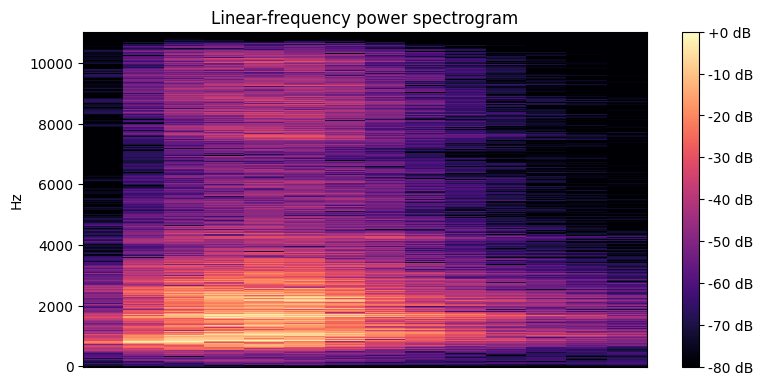

In [11]:
plt.figure(figsize=(20, 20))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

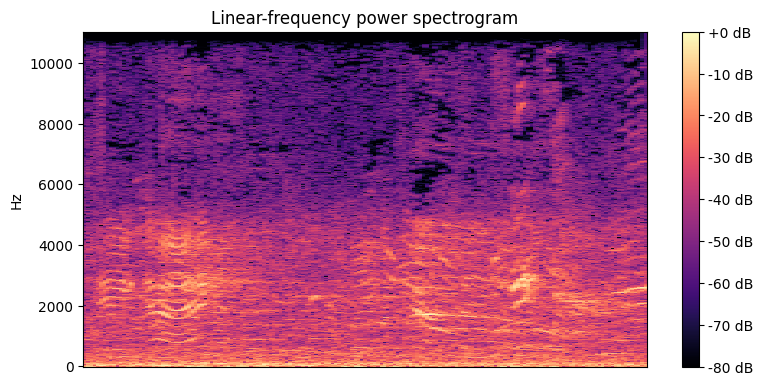

In [12]:
plt.figure(figsize=(20, 20))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

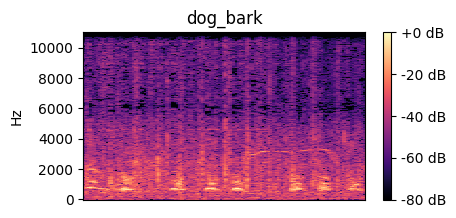

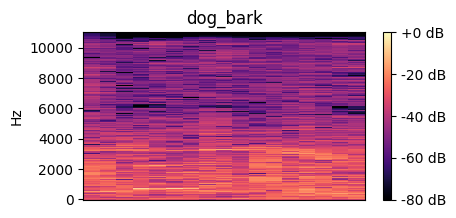

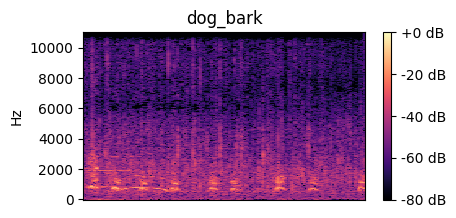

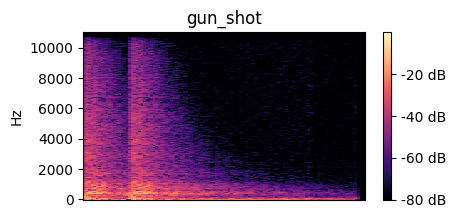

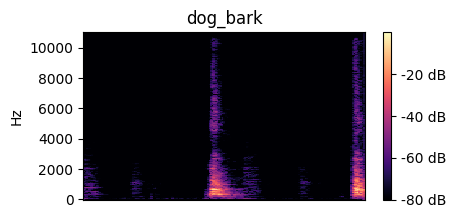

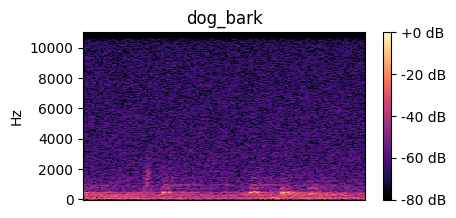

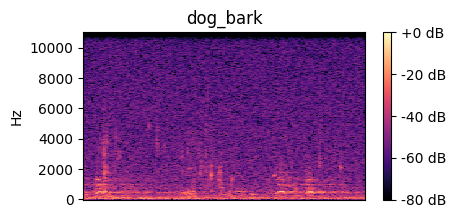

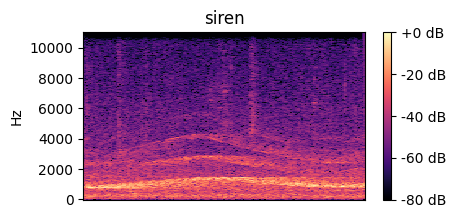

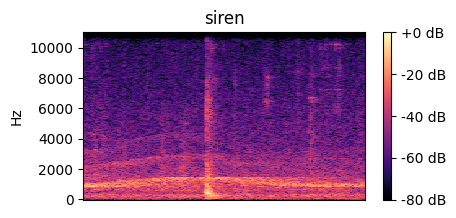

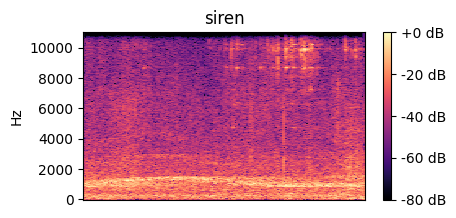

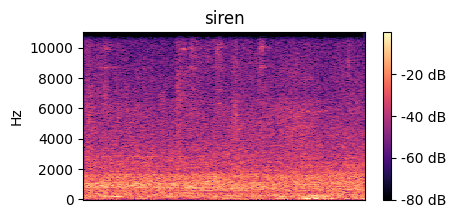

In [13]:
arr = np.array(df["slice_file_name"])
fold = np.array(df["fold"])
cla = np.array(df["class"])

for i in range(100, 121, 2):
    path = '../input/urbansound8k/fold' + str(fold[i]) + '/' + arr[i]
    data, sampling_rate = librosa.load(path)
    plt.figure(figsize=(10, 10))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(cla[i])

# Feature Extraction and Database Building

## Mel Spectrograms

* This raw audio is now converted to Mel Spectrograms. A Spectrogram captures the nature of the audio as an image by decomposing it into the set of frequencies that are included in it.

## MFCC

* For human speech, in particular, it sometimes helps to take one additional step and convert the Mel Spectrogram into MFCC (Mel Frequency Cepstral Coefficients). MFCCs produce a compressed representation of the Mel Spectrogram by extracting only the most essential frequency coefficients, which correspond to the frequency ranges at which humans speak.

In [14]:
# !pip install --no-cache-dir --upgrade resampy

In [15]:
# !pip install --no-cache-dir --upgrade librosa

In [16]:
# First restart kernel 
print("Librosa version:", librosa.__version__)
print("Resampy version:", resampy.__version__)

Librosa version: 0.10.2.post1
Resampy version: 0.4.3


In [18]:
def features_extract(file):
    sample,sample_rate = librosa.load(file_name,res_type='kaiser_fast')
    feature = librosa.feature.mfcc(y=sample,sr=sample_rate,n_mfcc=50,n_fft=1024)
    scaled_feature = np.mean(feature.T,axis=0)
    return scaled_feature

extracted = []
path = '../input/urbansound8k/'

for index_num,row in tqdm(df.iterrows()):
    file_name = os.path.join(os.path.abspath(path),'fold'+str(row["fold"])+'/',str(row['slice_file_name'])) 
    final_class_labels = row['class']   
    data= features_extract(file_name)    
    extracted.append([data,final_class_labels])

0it [00:00, ?it/s]

In [19]:
ext_df = pd.DataFrame(extracted,columns=['feature','class'])
ext_df

feature             class
0     [-302.21158, 69.556465, -124.38875, -50.66138,...          dog_bark
1     [-497.49588, 108.532524, -52.183617, 60.615326...  children_playing
2     [-531.8105, 120.17569, -46.226433, 51.95355, 0...  children_playing
3     [-488.22928, 102.17729, -34.55252, 53.13045, 1...  children_playing
4     [-519.33417, 112.80471, -52.25847, 60.23233, 2...  children_playing
...                                                 ...               ...
8727  [-470.80038, 134.84998, -50.82177, 35.83541, -...          car_horn
8728  [-419.70996, 86.23215, -44.575157, 52.246014, ...          car_horn
8729  [-375.78317, 112.08009, -46.08013, 35.412975, ...          car_horn
8730  [-415.52222, 125.33423, -54.730785, 34.484978,...          car_horn
8731  [-387.6192, 94.34236, -37.8204, 46.798058, -6....          car_horn

[8732 rows x 2 columns]

In [20]:
x = np.array(ext_df['feature'].tolist())
y = np.array(ext_df['class'].tolist())

In [21]:
le = LabelEncoder()

y = to_categorical(le.fit_transform(y))

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

print("Number of training samples = ", x_train.shape[0])
print("Number of testing samples = ",x_test.shape[0])

Number of training samples =  6985
Number of testing samples =  1747


In [26]:
from tensorflow.keras.layers import Input

num_labels = y.shape[1]
model = Sequential([
    Input(shape=(50,)),  
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(128, activation='relu'), 

    Dense(num_labels, activation='softmax')  
])

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 128)                 │           6,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 139,530 (545.04 KB)

 Trainable params: 139,530 (545.04 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [35]:
history = model.fit(
          x_train, 
          y_train, 
          batch_size=32, 
          epochs=100,
          validation_data=(x_test, y_test),
         )

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7879 - loss: 0.6312 - val_accuracy: 0.8443 - val_loss: 0.5154
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7882 - loss: 0.6446 - val_accuracy: 0.8409 - val_loss: 0.5042
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7828 - loss: 0.6594 - val_accuracy: 0.8466 - val_loss: 0.4890
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7940 - loss: 0.6354 - val_accuracy: 0.8546 - val_loss: 0.4944
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7790 - loss: 0.6404 - val_accuracy: 0.8477 - val_loss: 0.5009
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7833 - loss: 0.6664 - val_accuracy: 0.8460 - val_loss: 0.5444
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7709 - loss: 0.6726 - val_accuracy: 0.8540 - val_loss: 0.4955
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7863 - loss: 0.6480 - val_accu

In [39]:
def showAccVallLossPlt(history):
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

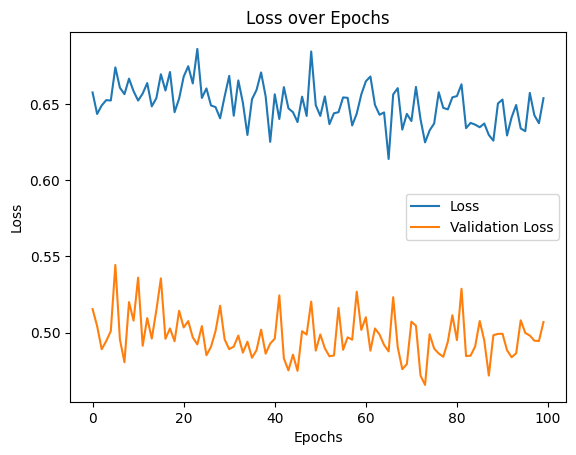

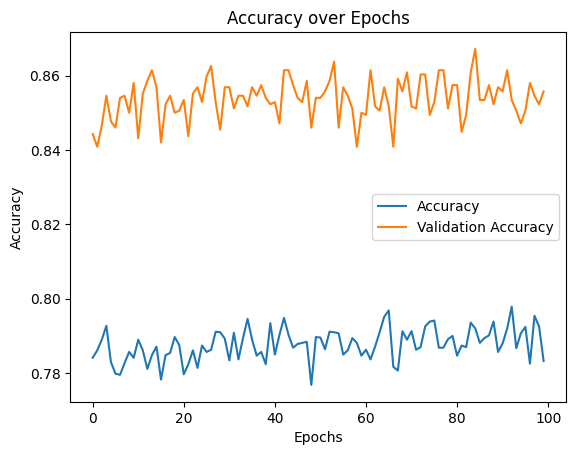

In [40]:
showAccVallLossPlt(history)

In [37]:
history2 = model.fit(
          x_train, 
          y_train, 
          batch_size=32, 
          epochs=200,
          validation_data=(x_test, y_test),
         )

Epoch 1/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7880 - loss: 0.6427 - val_accuracy: 0.8477 - val_loss: 0.4942
Epoch 2/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7971 - loss: 0.6225 - val_accuracy: 0.8661 - val_loss: 0.4698
Epoch 3/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7937 - loss: 0.6318 - val_accuracy: 0.8535 - val_loss: 0.4883
Epoch 4/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7910 - loss: 0.6378 - val_accuracy: 0.8586 - val_loss: 0.4873
Epoch 5/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7871 - loss: 0.6829 - val_accuracy: 0.8563 - val_loss: 0.5106
Epoch 6/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7740 - loss: 0.6841 - val_accuracy: 0.8592 - val_loss: 0.4833
Epoch 7/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7937 - loss: 0.6272 - val_accuracy: 0.8506 - val_loss: 0.4884
Epoch 8/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8031 - loss: 0.6281 - val_accu

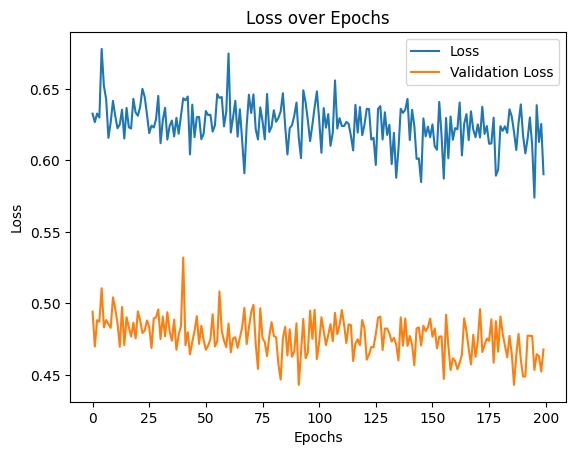

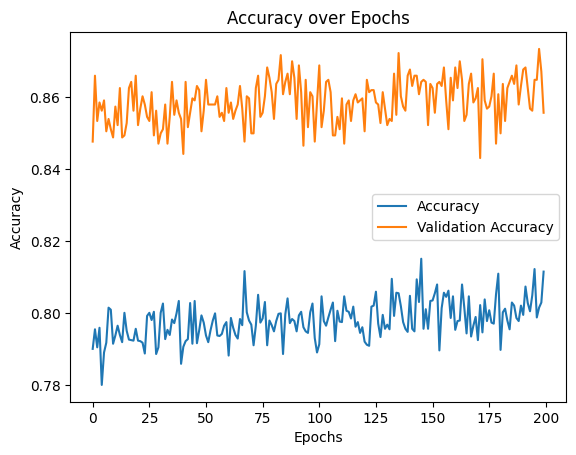

In [41]:
showAccVallLossPlt(history2)

Epoch 1/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8214 - loss: 0.5514 - val_accuracy: 0.8666 - val_loss: 0.4315
Epoch 2/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8185 - loss: 0.5855 - val_accuracy: 0.8729 - val_loss: 0.4504
Epoch 3/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8294 - loss: 0.5281 - val_accuracy: 0.8735 - val_loss: 0.4250
Epoch 4/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8262 - loss: 0.5446 - val_accuracy: 0.8575 - val_loss: 0.4475
Epoch 5/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8266 - loss: 0.5268 - val_accuracy: 0.8689 - val_loss: 0.4410
Epoch 6/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8271 - loss: 0.5210 - val_accuracy: 0.8609 - val_loss: 0.4532
Epoch 7/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8098 - loss: 0.5603 - val_accuracy: 0.8729 - val_loss: 0.4216
Epoch 8/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8201 - loss: 0.5412 - val_accu

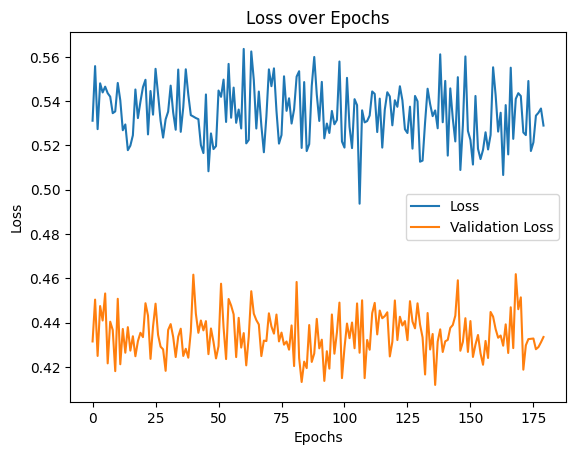

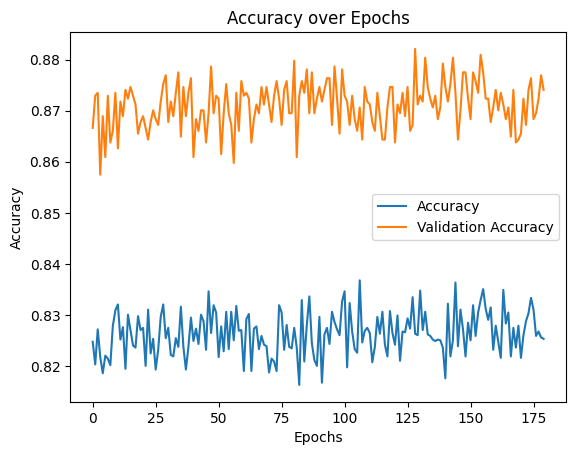

In [44]:
history3 = model.fit(
          x_train, 
          y_train, 
          batch_size=64, 
          epochs=180,
          validation_data=(x_test, y_test),
         )
showAccVallLossPlt(history3)

# Convolutional Layers

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input

num_labels = y.shape[1]
modelConv = Sequential([
    Input(shape=(50, 1)), 
    
    Conv1D(64, 3, activation='relu'), 
    MaxPooling1D(2),  

    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),

    Conv1D(256, 3, activation='relu'),
    MaxPooling1D(2),

    Flatten(),  

    Dense(128, activation='relu'),  
    Dropout(0.5),

    Dense(num_labels, activation='softmax')  
])

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 128)                 │           6,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 418,592 (1.60 MB)

 Trainable params: 139,530 (545.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 279,062 (1.06 MB)

In [47]:
modelConv.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

Epoch 1/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9828 - loss: 0.1402 - val_accuracy: 0.9015 - val_loss: 1.8261
Epoch 2/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9776 - loss: 0.1432 - val_accuracy: 0.9176 - val_loss: 1.6313
Epoch 3/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9911 - loss: 0.0308 - val_accuracy: 0.9210 - val_loss: 1.7338
Epoch 4/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9915 - loss: 0.0379 - val_accuracy: 0.9244 - val_loss: 1.8007
Epoch 5/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9943 - loss: 0.0231 - val_accuracy: 0.9244 - val_loss: 1.7916
Epoch 6/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9953 - loss: 0.0114 - val_accuracy: 0.9113 - val_loss: 2.2388
Epoch 7/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9917 - loss: 0.0532 - val_accuracy: 0.9159 - val_loss: 1.8339
Epoch 8/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9946 - loss: 0.0186 - val_accu

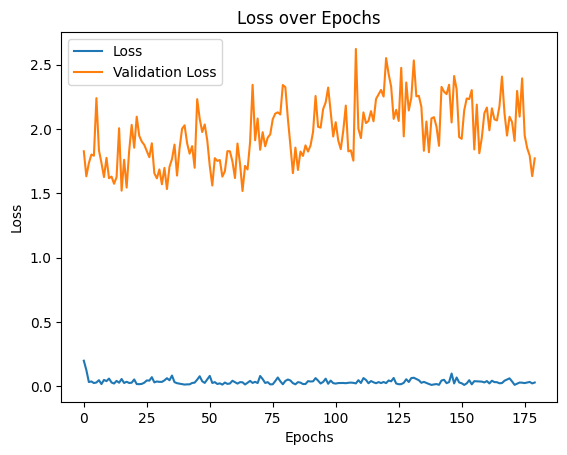

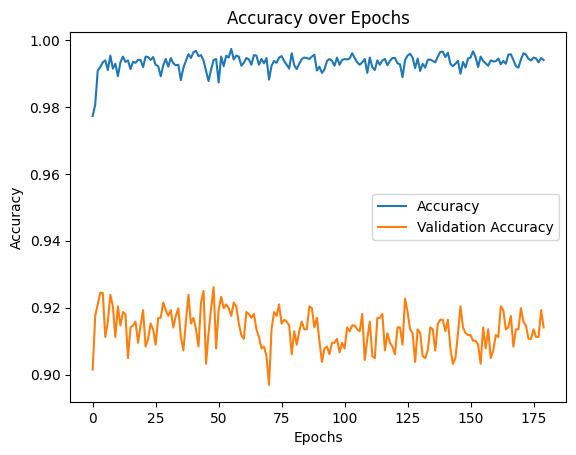

In [51]:
history4 = modelConv.fit(
          x_train, 
          y_train, 
          epochs=180,
          validation_data=(x_test, y_test),
         )
showAccVallLossPlt(history4)

Epoch 1/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9930 - loss: 0.0334 - val_accuracy: 0.9107 - val_loss: 2.0528
Epoch 2/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9902 - loss: 0.0389 - val_accuracy: 0.9067 - val_loss: 2.2391
Epoch 3/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9910 - loss: 0.0720 - val_accuracy: 0.9101 - val_loss: 2.0307
Epoch 4/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9918 - loss: 0.0331 - val_accuracy: 0.9113 - val_loss: 2.0656
Epoch 5/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9938 - loss: 0.0358 - val_accuracy: 0.9147 - val_loss: 1.8244
Epoch 6/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9898 - loss: 0.0444 - val_accuracy: 0.9096 - val_loss: 2.4958
Epoch 7/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9941 - loss: 0.0388 - val_accuracy: 0.9153 - val_loss: 2.2272
Epoch 8/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9899 - loss: 0.0646 - val_accu

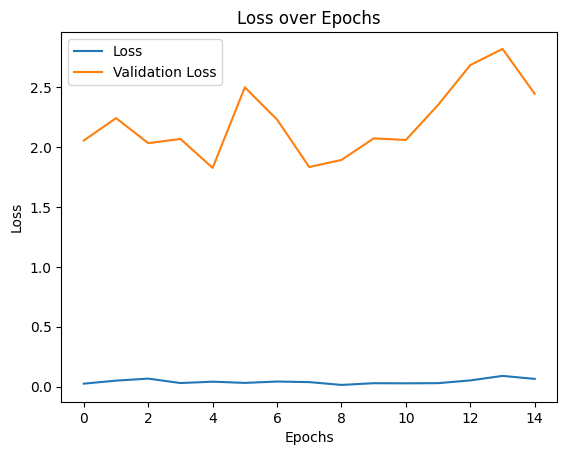

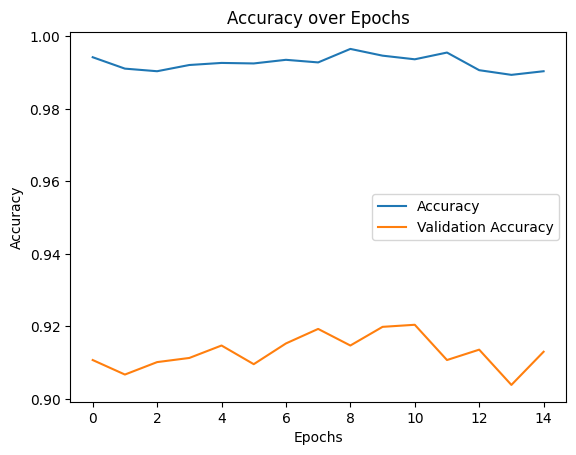

In [55]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history5=modelConv.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=180, callbacks=[early_stopping])
showAccVallLossPlt(history5)

In [67]:
from tensorflow.keras.layers import BatchNormalization

num_labels = y.shape[1]
modelConv2 = Sequential([
    Input(shape=(50, 1)), 
    
    Conv1D(64, 3, activation='relu'), 
    MaxPooling1D(2),
    BatchNormalization(),  #
    
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    BatchNormalization(),
    
    Conv1D(256, 3, activation='relu'),
    MaxPooling1D(2),
    BatchNormalization(),
    
    Flatten(),
    
    Dense(256, activation='relu'),  
    Dropout(0.5),
    
    Dense(128, activation='relu'),  
    Dropout(0.5),
    
    Dense(num_labels, activation='softmax')
])

modelConv2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelConv2.summary()


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)                   │ (None, 48, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_15 (MaxPooling1D)      │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 24, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_16 (Conv1D)                   │ (None, 22, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_16 (MaxPooling1D)      │ (None, 11, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 11, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 9, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_17 (MaxPooling1D)      │ (None, 4, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 4, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 421,898 (1.61 MB)

 Trainable params: 421,002 (1.61 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.3075 - loss: 2.1181 - val_accuracy: 0.6062 - val_loss: 1.3721
Epoch 2/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5369 - loss: 1.3342 - val_accuracy: 0.7270 - val_loss: 0.9520
Epoch 3/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6418 - loss: 1.0577 - val_accuracy: 0.7476 - val_loss: 0.7979
Epoch 4/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7261 - loss: 0.8674 - val_accuracy: 0.8048 - val_loss: 0.5977
Epoch 5/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7676 - loss: 0.7131 - val_accuracy: 0.8037 - val_loss: 0.6299
Epoch 6/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7971 - loss: 0.6386 - val_accuracy: 0.8472 - val_loss: 0.4523
Epoch 7/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8132 - loss: 0.5774 - val_accuracy: 0.8454 - val_loss: 0.4875
Epoch 8/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8329 - loss: 0.5191 - val_acc

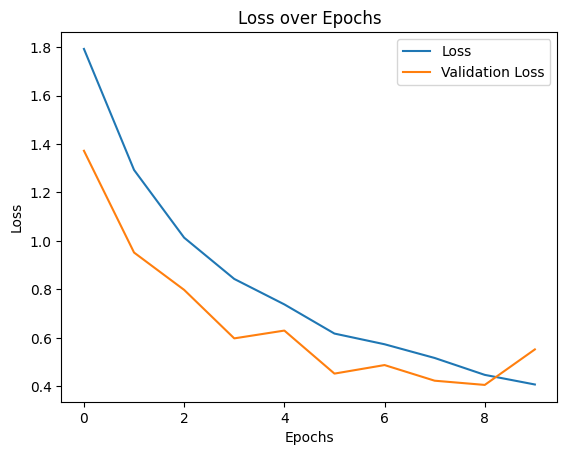

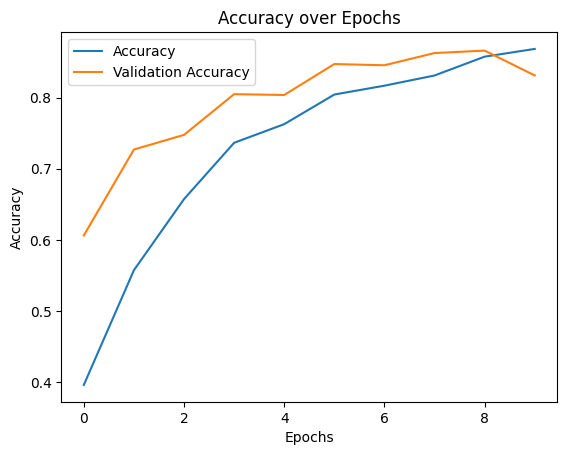

In [68]:
history6 = modelConv2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=200, batch_size=32,callbacks=[early_stopping])
showAccVallLossPlt(history6)

Epoch 1/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7968 - loss: 0.6810 - val_accuracy: 0.7928 - val_loss: 0.6441
Epoch 2/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8191 - loss: 0.5746 - val_accuracy: 0.8620 - val_loss: 0.4286
Epoch 3/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8784 - loss: 0.3907 - val_accuracy: 0.8981 - val_loss: 0.3446
Epoch 4/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8987 - loss: 0.3405 - val_accuracy: 0.9004 - val_loss: 0.3378
Epoch 5/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9124 - loss: 0.2643 - val_accuracy: 0.8970 - val_loss: 0.3242
Epoch 6/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9180 - loss: 0.2613 - val_accuracy: 0.8941 - val_loss: 0.3642
Epoch 7/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9206 - loss: 0.2413 - val_accuracy: 0.8987 - val_loss: 0.3814
Epoch 8/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9387 - loss: 0.1938 - val_accu

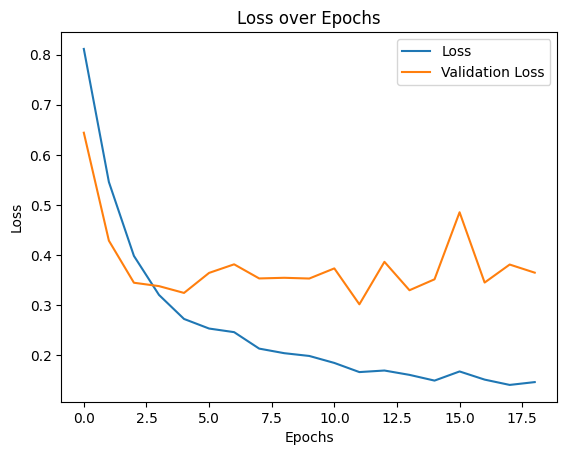

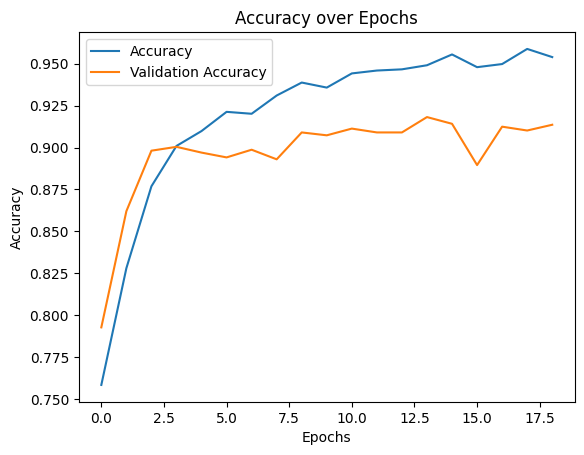

In [74]:
early_stop2 = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
history7 = modelConv2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=200, batch_size=32,callbacks=[early_stop2])
showAccVallLossPlt(history7)

In [75]:
def extract_feature(file_name):
    audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    fea = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=50)
    scaled = np.mean(fea.T,axis=0)
    return np.array([scaled])

In [76]:
def print_prediction(file_name):
    pred_fea = extract_feature(file_name) 
    pred_vector = np.argmax(model.predict(pred_fea), axis=-1)
    pred_class = le.inverse_transform(pred_vector)
    print("The predicted class is:", pred_class[0], '\n') 

In [77]:
df

slice_file_name    fsID       start         end  salience  fold  \
0       100032-3-0-0.wav  100032    0.000000    0.317551         1     5   
1     100263-2-0-117.wav  100263   58.500000   62.500000         1     5   
2     100263-2-0-121.wav  100263   60.500000   64.500000         1     5   
3     100263-2-0-126.wav  100263   63.000000   67.000000         1     5   
4     100263-2-0-137.wav  100263   68.500000   72.500000         1     5   
...                  ...     ...         ...         ...       ...   ...   
8727     99812-1-2-0.wav   99812  159.522205  163.522205         2     7   
8728     99812-1-3-0.wav   99812  181.142431  183.284976         2     7   
8729     99812-1-4-0.wav   99812  242.691902  246.197885         2     7   
8730     99812-1-5-0.wav   99812  253.209850  255.741948         2     7   
8731     99812-1-6-0.wav   99812  332.289233  334.821332         2     7   

      classID             class  
0           3          dog_bark  
1           2  children_playing  
2           2  children_playing  
3           2  children_playing  
4           2  children_playing  
...       ...               ...  
8727        1          car_horn  
8728        1          car_horn  
8729        1          car_horn  
8730        1          car_horn  
8731        1          car_horn  

[8732 rows x 8 columns]

In [78]:
print_prediction('../input/urbansound8k/fold2/100652-3-0-2.wav')
ipd.Audio('../input/urbansound8k/fold2/100652-3-0-2.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
The predicted class is: dog_bark 



In [79]:
print_prediction('../input/urbansound8k/fold5/100263-2-0-137.wav')
ipd.Audio('../input/urbansound8k/fold5/100263-2-0-137.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
The predicted class is: children_playing 



In [80]:
print_prediction('../input/urbansound8k/fold7/102853-8-0-2.wav')
ipd.Audio('../input/urbansound8k/fold7/102853-8-0-2.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
The predicted class is: siren 



In [81]:
print_prediction('/kaggle/input/urbansound8k/fold4/107653-9-0-3.wav')
ipd.Audio('/kaggle/input/urbansound8k/fold4/107653-9-0-3.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
The predicted class is: street_music 

